Audio[WARNING]: Modifying input wav from size 58741 to 58688
Audio[INFO]: change in number of samples: -53 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 917, reduced 916.984375


Syllables for 1_0004

,syl,start,stop,audio
0,0,0.00000,0.09288,data/korean-single-speaker/kss/1/1_0004.wav
1,그,0.09288,0.24152,data/korean-single-speaker/kss/1/1_0004.wav
2,애,0.24152,0.33564,data/korean-single-speaker/kss/1/1_0004.wav
3,0,0.33564,0.35846,data/korean-single-speaker/kss/1/1_0004.wav
4,전,0.35846,0.56929,data/korean-single-speaker/kss/1/1_0004.wav
5,~ᆫ화,0.56929,0.67854,data/korean-single-speaker/kss/1/1_0004.wav
6,번,0.67854,0.84911,data/korean-single-speaker/kss/1/1_0004.wav
7,~ᆫ호,0.84911,0.89335,data/korean-single-speaker/kss/1/1_0004.wav
8,알,0.89335,1.04414,data/korean-single-speaker/kss/1/1_0004.wav
9,0,1.04414,1.06376,data/korean-single-speaker/kss/1/1_0004.wav


Silence only rows for 1_0004

,syl,start,stop,audio
0,0,0.00000,0.09288,data/korean-single-speaker/kss/1/1_0004.wav
3,0,0.33564,0.35846,data/korean-single-speaker/kss/1/1_0004.wav
9,0,1.04414,1.06376,data/korean-single-speaker/kss/1/1_0004.wav


wav shape: (58687,)
rms shape: (917,)
mfcc shape: (8, 917)
sliding windows shape: (870, 48)


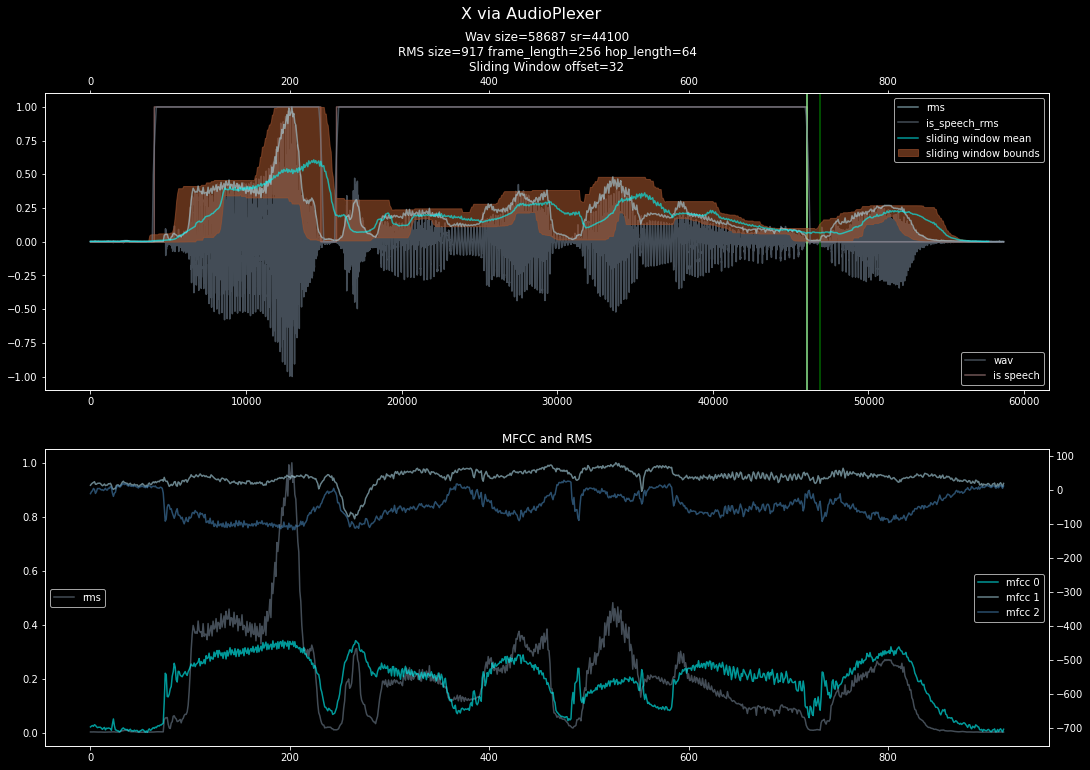

audio_plexer.py 

import math
import wave
import librosa
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from audio import Audio
from log import Log


# Handles time to samples conversion so it is consistent for all instances
class AudioPlexer:

    # Will verify the wav_files all have the specified sample rate
    # if sample rate is not provided, use the first wav file's sample rate.

    # PERFORMANCE NOTE: We're storing the raw wav file
    def __init__(self, audio_paths, sr=None, n_fft=256, n_hops=4, sliding_window_size=64, sliding_offset=0):
        self.log = Log.set(self.__class__.__name__)
        self.audio_paths = audio_paths
        self.sr = sr
        self.n_fft = n_fft
        self.n_hops = n_hops
        self.hop_length = math.ceil(self.n_fft/self.n_hops)
        self.sliding_window_size = sliding_window_size
        self.sliding_offset = sliding_offset

        # validate all files have the same sample rate
        for fn in self.audio_paths:
            with wave.open(fn, 'rb') as f:
                sr_ = f.getframerate()
                if self.sr is None:
                    self.sr = sr_
                assert self.sr == sr_

        self.audios = [Audio(f, sr=self.sr, n_fft=self.n_fft, n_hops=n_hops) for f in self.audio_paths]
        self.size = sum([a.size for a in self.audios])

    # So brittle it hurts
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            audio_paths_eq = np.array_equal(self.audio_paths, other.audio_paths) if isinstance(self.audio_paths, np.ndarray) else self.audio_paths == other.audio_paths
            return (audio_paths_eq and
                    self.sr == other.sr and
                    self.n_fft == other.n_fft and
                    self.n_hops == other.n_hops and
                    self.sliding_window_size == other.sliding_window_size and
                    self.sliding_offset == other.sliding_offset)
        else:
            return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def wav(self):
        return np.concatenate([a.wav for a in self.audios])

    def mfcc(self):
        return np.concatenate([a.mfcc for a in self.audios], axis=1)

    def rms(self):
        return np.concatenate([a.rms for a in self.audios], axis=1)

    # Return numpy array matching audio size
    def val_from_interval(self, df, ivl_cols=None, val_col='value', missing_val=None):
        if ivl_cols is None:
            ivl_cols = ['start', 'stop']
        a_dfs = [self.df_per_audio(df, a.path, val_col=val_col) for a in self.audios]
        kw = {'ivl_cols': ivl_cols, 'missing_val': missing_val}
        return np.concatenate([a.val_from_interval(a_df, **kw) for (a_df, a) in zip(a_dfs, self.audios)])

    # TODO: Align with audio class, on fix for speech boolean test.
    def speech_from_interval(self, df, ivl_cols=None, missing_val=None):
        if ivl_cols is None:
            ivl_cols = ['start', 'stop']
        a_dfs = [df.loc[df['audio'] == a.path] for a in self.audios]
        kw = {'ivl_cols': ivl_cols, 'missing_val': missing_val}
        return np.concatenate([a.speech_from_interval(a_df, **kw) for (a_df, a) in zip(a_dfs, self.audios)])


    def df_per_audio(self, full_a_df, audio_path, val_col='syl'):
        df_for_audio_path = full_a_df.loc[full_a_df['audio'] == audio_path]
        df_for_audio_path.reindex(['start', 'stop', val_col, 'audio'])
        # TODO: Figure out how to pass the condition as an argument
        df_for_audio_path['value'] = df_for_audio_path[val_col] != '0'
        return df_for_audio_path

    def to_rms(self, x):
        rms = librosa.feature.rms(y=x, frame_length=self.n_fft, hop_length=self.hop_length)
        return librosa.util.normalize(rms, axis=1)

    # given an X and y, will take n samples of X (ordered series)
    # Example, for len(X) = len(y) = 1000, and a frame_length=5 and y_offset=4
    #  y3, [x0, x1, x2, x3, x4]
    #  y4, [x1, x2, x3, x4, x5]
    #  y5, [x2, x3, x4, x

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from audio_plexer import AudioPlexer
from kss_textgrid import KssTextGrid
from display import Disp
disp = Disp(display)
plt.style.use('dark_background')


import math
import wave
import librosa
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from audio import Audio
from log import Log


# Handles time to samples conversion so it is consistent for all instances
class AudioPlexer:

    # Will verify the wav_files all have the specified sample rate
    # if sample rate is not provided, use the first wav file's sample rate.

    # PERFORMANCE NOTE: We're storing the raw wav file
    def __init__(self, audio_paths, sr=None, n_fft=256, n_hops=4, sliding_window_size=64, sliding_offset=0):
        self.log = Log.set(self.__class__.__name__)
        self.audio_paths = audio_paths
        self.sr = sr
        self.n_fft = n_fft
        self.n_hops = n_hops
        self.hop_length = math.ceil(self.n_fft/self.n_hops)
        self.sliding_window_size = sliding_window_size
        self.sliding_offset = sliding_offset

        # validate all files have the same sample rate
        for fn in self.audio_paths:
            with wave.open(fn, 'rb') as f:
                sr_ = f.getframerate()
                if self.sr is None:
                    self.sr = sr_
                assert self.sr == sr_

        self.audios = [Audio(f, sr=self.sr, n_fft=self.n_fft, n_hops=n_hops) for f in self.audio_paths]
        self.size = sum([a.size for a in self.audios])

    # So brittle it hurts
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            audio_paths_eq = np.array_equal(self.audio_paths, other.audio_paths) if isinstance(self.audio_paths, np.ndarray) else self.audio_paths == other.audio_paths
            return (audio_paths_eq and
                    self.sr == other.sr and
                    self.n_fft == other.n_fft and
                    self.n_hops == other.n_hops and
                    self.sliding_window_size == other.sliding_window_size and
                    self.sliding_offset == other.sliding_offset)
        else:
            return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def wav(self):
        return np.concatenate([a.wav for a in self.audios])

    def mfcc(self):
        return np.concatenate([a.mfcc for a in self.audios], axis=1)

    def rms(self):
        return np.concatenate([a.rms for a in self.audios], axis=1)

    # Return numpy array matching audio size
    def val_from_interval(self, df, ivl_cols=None, val_col='value', missing_val=None):
        if ivl_cols is None:
            ivl_cols = ['start', 'stop']
        a_dfs = [self.df_per_audio(df, a.path, val_col=val_col) for a in self.audios]
        kw = {'ivl_cols': ivl_cols, 'missing_val': missing_val}
        return np.concatenate([a.val_from_interval(a_df, **kw) for (a_df, a) in zip(a_dfs, self.audios)])

    # TODO: Align with audio class, on fix for speech boolean test.
    def speech_from_interval(self, df, ivl_cols=None, missing_val=None):
        if ivl_cols is None:
            ivl_cols = ['start', 'stop']
        a_dfs = [df.loc[df['audio'] == a.path] for a in self.audios]
        kw = {'ivl_cols': ivl_cols, 'missing_val': missing_val}
        return np.concatenate([a.speech_from_interval(a_df, **kw) for (a_df, a) in zip(a_dfs, self.audios)])


    def df_per_audio(self, full_a_df, audio_path, val_col='syl'):
        df_for_audio_path = full_a_df.loc[full_a_df['audio'] == audio_path]
        df_for_audio_path.reindex(['start', 'stop', val_col, 'audio'])
        # TODO: Figure out how to pass the condition as an argument
        df_for_audio_path['value'] = df_for_audio_path[val_col] != '0'
        return df_for_audio_path

    def to_rms(self, x):
        rms = librosa.feature.rms(y=x, frame_length=self.n_fft, hop_length=self.hop_length)
        return librosa.util.normalize(rms, axis=1)

    # given an X and y, will take n samples of X (ordered series)
    # Example, for len(X) = len(y) = 1000, and a frame_length=5 and y_offset=4
    #  y3, [x0, x1, x2, x3, x4]
    #  y4, [x1, x2, x3, x4, x5]
    #  y5, [x2, x3, x4, x5, x6]
    #  ...
    #  y999, [x996, x997, x998, x999, x1000]
    def sliding_window_features(self, X, y=None, window=None, offset=None):
        if window is None:
            window = self.sliding_window_size
        if offset is None:
            offset = self.sliding_offset

        axis = len(X.shape) - 1
        # we will need to reduce (by slicing) X to match y when we are done
        slc_a = [slice(None)] * (axis + 1)
        x_ = sliding_window_view(X, window, axis=axis)

        y_ = None

        # match y with the correct x
        if y is not None:
            y_ = y.flatten()[offset:x_.shape[axis]]
            slc_a[axis] = slice(0, y_.shape[0])

        slc = tuple(slc_a)
        # return same shape
        return x_[slc], y_

# wav and TextGrid locations
data_dir = 'data/korean-single-speaker/kss/1'
kss_id = '1_0004'
kss_file_part = f'{data_dir}/{kss_id}'
audio_path_ = f'{kss_file_part}.wav'
audio_paths_ = [audio_path_]

ap_params_example = {
    'n_fft': 256,
    'n_hops':  4,
    'sliding_window_size': 48,
    'sliding_offset': 32
}
ap = AudioPlexer(audio_paths_, **ap_params_example)

ap_rms = ap.rms().flatten()
ap_mfcc = ap.mfcc()
ap_windows, _ = ap.sliding_window_features(ap_rms)

# Creat DF from TextGrid data
syls_df = KssTextGrid(kss_id, data_dir,).syls_df()
disp.obj(syls_df, f'Syllables for {kss_id}')
disp.obj(syls_df[syls_df['syl'] == '0'], f'Silence only rows for {kss_id}')

# Convert DF to values matching wav and rms size
is_speech_wav = ap.speech_from_interval(syls_df, missing_val=False)
is_speech_rms = ap.to_rms(is_speech_wav.astype(float)).flatten()

print(f'wav shape: {ap.wav().shape}')
print(f'rms shape: {ap_rms.shape}')
print(f'mfcc shape: {ap_mfcc.shape}')
print(f'sliding windows shape: {ap_windows.shape}')

last0_start = 1.04414 * ap.sr
last0_end = 1.06376 * ap.sr

# plotting
align_ap_windows = np.pad(ap_windows, (ap.sliding_offset, 0), 'edge')
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('X via AudioPlexer', fontsize=16)

ax1.set_title(f'Wav size={ap.size} sr={ap.sr}\nRMS size={len(ap_rms)} frame_length={ap.n_fft} hop_length={ap.hop_length}\nSliding Window offset={ap.sliding_offset}')
ax1.plot(ap.wav(), color='slategray', alpha=0.6, label='wav')
ax1.plot(is_speech_wav, color='rosybrown', alpha=0.6, label='is speech')
ax1.axvline(last0_start, -1.1, 1.1, color='lightgreen')
ax1.axvline(last0_end, -1.1, 1.1, color='darkgreen')

ax1a = ax1.twiny()
ax1a.plot(ap_rms, color='lightblue', alpha=0.6, label='rms')
ax1a.plot(is_speech_rms, color='slategray', alpha=0.6, label='is_speech_rms')
ax1a.plot(np.mean(align_ap_windows, axis=1), color='cyan', alpha=0.6, label=f'sliding window mean')
ax1a.fill_between(range(align_ap_windows.shape[0]),
                  np.min(align_ap_windows, axis=1), np.max(align_ap_windows, axis=1),
                  color='sienna', alpha=0.6, label='sliding window bounds')
ax1.legend(loc='lower right')
ax1a.legend(loc='upper right')

ax2.set_title(f'MFCC and RMS')
ax2.plot(ap_rms, color='slategray', alpha=0.6, label='rms')
ax2.legend(loc='center left')

ax2a = ax2.twinx()
ax2a.plot(ap_mfcc[0], color='cyan', alpha=0.6, label='mfcc 0')
ax2a.plot(ap_mfcc[1], color='lightblue', alpha=0.6, label='mfcc 1')
ax2a.plot(ap_mfcc[2], color='steelblue', alpha=0.6, label='mfcc 2')
ax2a.legend(loc='center right')

plt.show()

disp.code('audio_plexer.py', label='audio_plexer.py ')